# Naives Bayes Algo

# Importing the dataset

In [1]:
import os
import numpy as np
import pandas as pd
train_df = pd.read_csv("train-balanced-sarcasm.csv")
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


# Dropping the rows in which the 'comment' is missing

In [2]:
train_df.dropna(subset=['comment'], inplace=True)
print(train_df.iloc[:, :-1].isnull().sum())
print(train_df.iloc[:,-1].isnull().sum())

label          0
comment        0
author         0
subreddit      0
score          0
ups            0
downs          0
date           0
created_utc    0
dtype: int64
0


# Counting the number of values of corresponding 'label's to check whether the dataset is balanced.

In [3]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

# Spliting the data into training and validation parts

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

# Distribution of lengths for sarcastic and normal comments

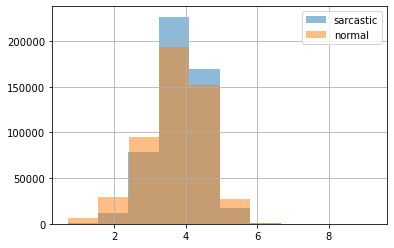

In [5]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

# Analyzing whether some subreddits are more sarcastic on average than others

In [6]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


# Sorting the result in decreasing order of 'mean'

In [7]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)


,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


# Checking whether there are same amounts of sarcastic and non-sarcastic comments

In [8]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


# Sorting the result in decreasing order of 'mean' where score >= 0

In [9]:
sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
0,58141,0.612752,35626
20,3096,0.561370,1738
34,1071,0.556489,596
26,1874,0.554429,1039
59,315,0.552381,174
18,3951,0.551759,2180
13,7277,0.546929,3980
17,4404,0.545867,2404
40,722,0.545706,394


# Sorting the result in decreasing order of 'mean' where score < 0

In [10]:
sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


# Tf-Idf vectorization 

In [11]:
text_transformer = TfidfVectorizer(ngram_range=(1, 2),max_features=50000,min_df=2)
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)

In [12]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

# Transformations for comments and subreddits

In [13]:
X_train_text = tf_idf_texts.fit_transform(train_texts)
X_test_text = tf_idf_texts.transform(valid_texts)

In [14]:
X_train_subreddit = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddit = tf_idf_subreddits.transform(valid_subreddits)

In [15]:
from scipy.sparse import hstack
X_train = hstack([X_train_text, X_train_subreddit])
X_valid = hstack([X_test_text, X_valid_subreddit])

# Training the model

In [16]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.7min finished


LogisticRegression(C=1, n_jobs=4, random_state=17, verbose=1)

In [17]:
valid_pred = logit.predict(X_valid)

# Multinomial Naive Bayes classifier

In [18]:
# fit the training dataset on the NB classifier
from sklearn.naive_bayes import MultinomialNB
Naive = MultinomialNB()
Naive.fit(X_train_text,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test_text)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score( y_valid,predictions_NB)*100)

Naive Bayes Accuracy Score ->  70.48564667146826


# Plotting the confusion matrix

In [19]:
tfidf_logit_pipeline = Pipeline([('text_transformer', text_transformer), 
                                 ('logit', logit)])
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

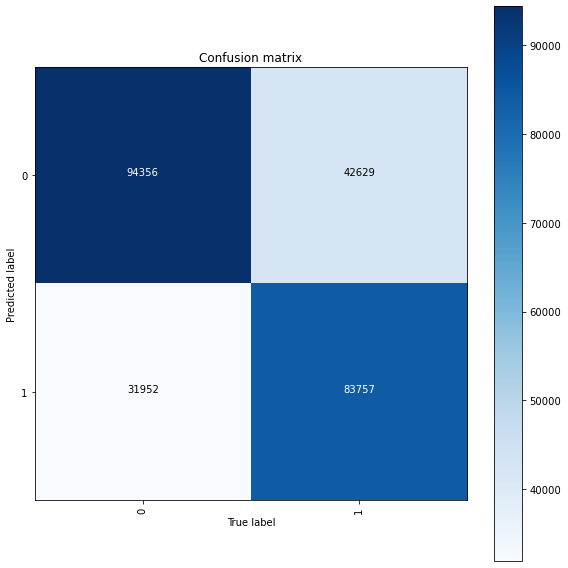

In [20]:
plot_confusion_matrix(y_valid, predictions_NB, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [20]:
import pickle
# Saving model to disk
pickle.dump(Naive, open('nbmodel.pkl','wb'))

# Loading model to compare the results
model = pickle.load(open('nbmodel.pkl','rb'))